In [1]:
import cv2 
import numpy as np 
import mediapipe as mp 
import matplotlib.pyplot as plt 

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [3]:
path1 = "/home/anindya/Documents/Github/YogaPosGNN/videos/video2.mkv"
path2 = '/home/anindya/Documents/Atelta/AteltaWebStream/RawData/UnderTheInfluenceChoreo.mp4'

In [4]:
def get_image_instance(video_path, instance=1000):
    cap = cv2.VideoCapture(video_path)
    counter = 0

    while True:
        counter += 1
        ret, frame = cap.read() 
        if counter > instance : break 
    return frame 

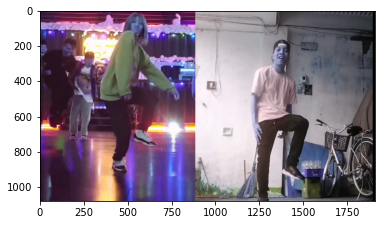

In [5]:
vid1_instance = get_image_instance(path1, 620)
plt.imshow(vid1_instance)

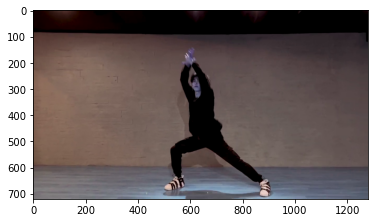

In [6]:
vid2_instance = get_image_instance(path2, 620)
plt.imshow(vid2_instance)

In [7]:
# seperating teacher and actor

inst_11, inst_12 = vid1_instance[:, :750, :], vid1_instance[:, 890:, :]

In [8]:
def predict_on_image(image, draw=False):
    BG_COLOR = (192, 192, 192) # gray
    with mp_pose.Pose(static_image_mode=True, 
                      model_complexity=2, 
                      enable_segmentation=False, min_detection_confidence=0.28) as pose:
        
        image_height, image_width, _ = image.shape
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        if draw:
            if not results.pose_landmarks:
                return None, None
            print(
                f'Nose coordinates: ('
                f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
                f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
            )

            annotated_image = image.copy()
            mp_drawing.draw_landmarks(
                annotated_image,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            # Plot pose world landmarks.
            mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
            return annotated_image, results
        else:
            return results

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Nose coordinates: (552.4471253156662, 88.75345945358276)


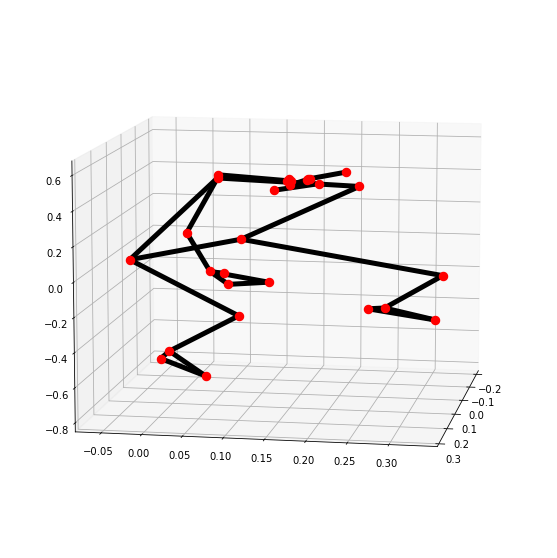

In [9]:
inst_11_annotated, inst11_result = predict_on_image(inst_11, draw=True)

Nose coordinates: (492.4090790748596, 246.39499425888062)


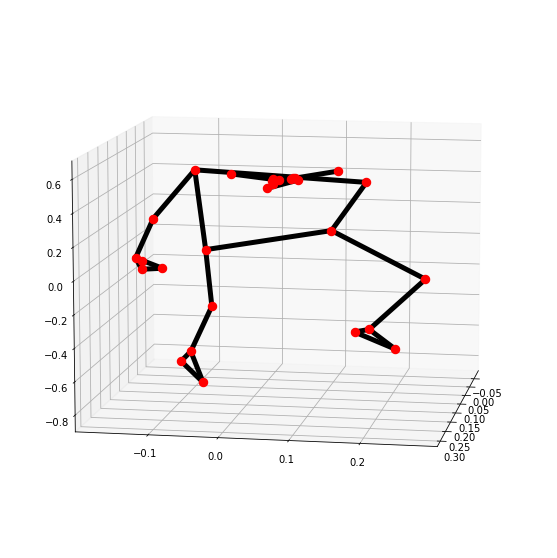

In [10]:
inst_12_annotated, inst12_result = predict_on_image(inst_12, draw=True)

Nose coordinates: (624.8737335205078, 287.290678024292)


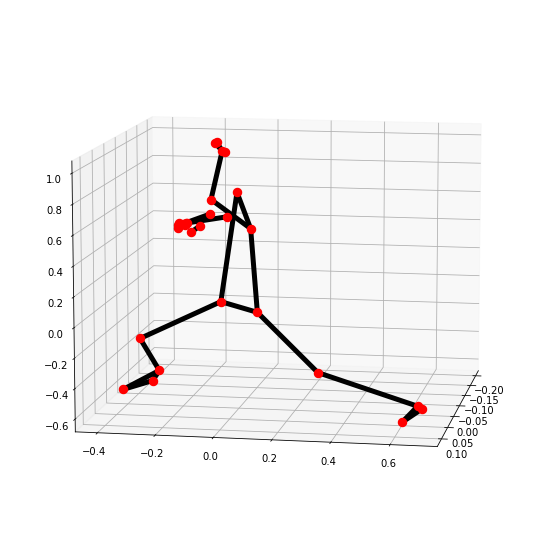

In [11]:
inst_2_annotated, inst_2_result = predict_on_image(vid2_instance, draw=True)

In [12]:
import numpy as np
import matplotlib.pyplot as plt

x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)
y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].imshow(inst_11_annotated)
axes[1].imshow(inst_12_annotated)
axes[2].imshow(inst_2_annotated)

fig.tight_layout()

### Custom landmark

In [13]:
import cv2
import math


def draw_custom_landmark(
    image,
    results,
    connection,
    mask_background=False,
    result_conversion=True,
    indices_to_avoid_nodes=None,
    indices_to_avoid_edges=None,
    dot_color=(0, 255, 0),
    line_color=(0, 0, 255),
    diameter=6,
    line_width=3,
):
    """
    image : numpy.ndarray,
    landmarks : mediapipe_landmarks.landmark,
    indices_to_avoid_nodes : the indices to avoid during drawing for the nodes,
    indices_to_avoid_edges : the indices to avoid during drawing for the edges,
    dot_color : the color of the nodes,
    line_color : the color of the edges,
    diameter : the diameter of the circle of the nodes,
    line_width : the width of the circle
    """
    # TODO : draw a trivial edge as a hand to palm joint
    # TODO : Have to make compatible with multi landmarks, though it could be done explicitely

    height, width, _ = image.shape
    connection = list(connection)
    
    if mask_background:
        image = np.zeros_like(image)
        
    if result_conversion:
        landmarks = []
        for landmark in results.pose_landmarks.landmark:
            landmarks.append((landmark.x, landmark.y))
    else:
        landmarks = results

    keypoints = []

    for idx, landmark in enumerate(landmarks):
        x, y = landmark

        x_px = int(min(math.floor(x * width), width - 1))
        y_px = int(min(math.floor(y * height), height - 1))
        keypoints.append((x_px, y_px))

        if indices_to_avoid_nodes is not None and idx in indices_to_avoid_nodes:
            continue

        else:
            cv2.circle(image, (int(x_px), int(y_px)), diameter, dot_color, -1)

    for inx, conn in enumerate(connection):
        from_ = conn[0]
        to_ = conn[1]
        if indices_to_avoid_edges is not None and from_ in indices_to_avoid_edges:
            continue
        else:
            if keypoints[from_] and keypoints[to_]:
                cv2.line(image, keypoints[from_], keypoints[to_], line_color, line_width)
            else:
                continue
    return image

In [14]:
img = draw_custom_landmark(
    inst_11, results=inst11_result, 
    mask_background=True,
    connection=mp_pose.POSE_CONNECTIONS
)

In [15]:
plt.imshow(img)

### Normalization of the points for same co-ordinate system

In [16]:
def convert_results_to_numpy(results, _3d=False):
    landmarks = []

    for landmark in results.pose_landmarks.landmark:
        if not _3d:
            landmarks.append((landmark.x, landmark.y))
        else:
            landmarks.append((landmark.x, landmark.y, landmark.z))
    
    return np.array(landmarks)

In [17]:
landmark11 = convert_results_to_numpy(inst11_result)
landmark12 = convert_results_to_numpy(inst12_result)
landmark2 = convert_results_to_numpy(inst_2_result)

In [18]:
def scale_relative_landmarks_pairs(landmarks1, landmarks2):
    
    """
    Will scale one landmark w.r.t other landmark.
    Here first landmark will be scaled w.r.t. second landmark 
    """
    
    landmarks1[:, 0] = landmarks1[:, 0] - min(landmarks1[:, 0])
    landmarks1[:, 1] = landmarks1[:, 1] - min(landmarks1[:, 1])

    landmarks2[:, 0] = landmarks2[:, 0] - min(landmarks2[:, 0])
    landmarks2[:, 1] = landmarks2[:, 1] - min(landmarks2[:, 1])
    
    resize_x = max(landmarks2[:, 0]) / max(landmarks1[:, 0])
    resize_y = max(landmarks2[:, 1]) / max(landmarks1[:, 1])
    
    landmarks1[:, 0] = landmarks1[:, 0] * resize_x
    landmarks1[:, 1] = landmarks1[:, 1] * resize_y
    
    return landmarks1

In [19]:
landmark2 = scale_relative_landmarks_pairs(landmark2, landmark11)

In [20]:
from typing import List, Union, Tuple


def draw_keypoints(image: np.ndarray, 
                   landmarks: Union[list, np.ndarray], connection: List[Tuple[int, int]], 
                   dot_color: Tuple[int, int, int], line_color: Tuple[int, int,int], 
                   diameter=6,line_width=3) -> None:
    height, width, _ = image.shape
    
    keypoints = []
    for idx, landmark in enumerate(landmarks):
        x, y = landmark

        x_px = int(min(math.floor(x * width), width - 1))
        y_px = int(min(math.floor(y * height), height - 1))
        keypoints.append((x_px, y_px))
        cv2.circle(image, (int(x_px), int(y_px)), diameter, dot_color, -1)
    
    for inx, conn in enumerate(connection):
        from_ = conn[0]
        to_ = conn[1]
    
        if keypoints[from_] and keypoints[to_]:
            cv2.line(image, keypoints[from_], keypoints[to_], line_color, line_width)
        else:
            continue
    return image 
    
    

def draw_landmarks_from_landmark(landmarks_list : List[np.ndarray], dot_colors: List[Tuple[int, int, int]], 
                                 line_colors: Tuple[int, int, int], canvas_shape = (1080, 750, 3)) -> None:
    
    canvas = np.zeros(canvas_shape, dtype=np.uint8)
    for landmarks, dot_color, line_color in zip(landmarks_list, dot_colors, line_colors):
        canvas = draw_keypoints(canvas, 
                                landmarks, 
                                connection=mp_pose.POSE_CONNECTIONS, 
                                dot_color=dot_color, line_color=line_color)
    plt.imshow(canvas)

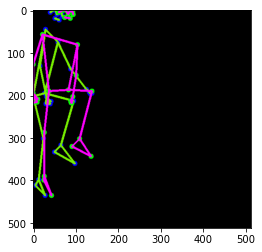

In [21]:
landmarks_from_first_instance1 = draw_landmarks_from_landmark(
    landmarks_list=[scale_relative_landmarks_pairs(landmark11, landmark12), landmark12], 
    dot_colors=[(0, 0, 255), (0, 255, 0)], 
    line_colors=[(120, 240, 0), (314, 0, 400)], 
    canvas_shape=(512, 512, 3)
)

In [22]:
landmarks_from_first_instance1 = draw_landmarks_from_landmark(
    landmarks_list=[landmark2, scale_relative_landmarks_pairs(landmark12, landmark2)], 
    dot_colors=[(0, 0, 255), (0, 255, 0)], 
    line_colors=[(120, 240, 0), (314, 0, 400)], canvas_shape=(750, 750, 3)
)

### Latest Update (Doing just with landmarks of two different image)

In [23]:
l1, l2 = landmark11.copy(), landmark2.copy()

In [24]:
canvas = np.zeros((1080, 750, 3), dtype=np.uint8)

In [25]:
height, width, _ = canvas.shape
center1_x, center1_y = (height // 2, width //2)

In [26]:
keypoints1_center_x, keypoints1_center_y = l1.mean(axis=0)[:2]
keypoints1_center_x = keypoints1_center_x * height
keypoints1_center_y = keypoints1_center_y * width

In [27]:
diff_x, diff_y = center1_x - keypoints1_center_x, center1_y - keypoints1_center_y

In [28]:
l1_ = l1.copy()

In [29]:
l1_[:,0] += diff_x
l1_[:,1] += diff_y

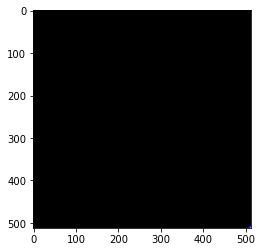

In [30]:
landmarks_from_first_instance1 = draw_landmarks_from_landmark(
    landmarks_list=[l1_], 
    dot_colors=[(0, 0, 255), (0, 255, 0)], 
    line_colors=[(120, 240, 0), (314, 0, 400)], 
    canvas_shape=(512, 512, 3)
)

In [31]:
l1_[:, 0] /= height
l1_[:, 1] /= width

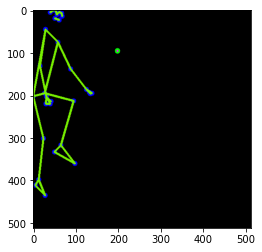

In [32]:
landmarks_from_first_instance1 = draw_landmarks_from_landmark(
    landmarks_list=[l1, l1_], 
    dot_colors=[(0, 0, 255), (0, 255, 0)], 
    line_colors=[(120, 240, 0), (314, 0, 400)], 
    canvas_shape=(512, 512, 3)
)

In [33]:
# calculate the bounding box of keypoints

keypoints = l1.copy()
image = canvas

x_min, y_min = keypoints[:, 0].min(), keypoints[:, 1].min()
x_max, y_max = keypoints[:, 0].max(), keypoints[:, 1].max()

# calculate the center of bounding box
bbox_center_x, bbox_center_y = (x_max + x_min) / 2, (y_max + y_min) / 2
center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
diff_x, diff_y = center_x - bbox_center_x, center_y - bbox_center_y

# translate keypoints
keypoints[:, 0] += diff_x
keypoints[:, 1] += diff_y

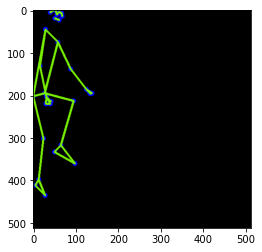

In [34]:
draw_landmarks_from_landmark(
    landmarks_list=[l1], 
    dot_colors=[(0, 0, 255), (0, 255, 0)], 
    line_colors=[(120, 240, 0), (314, 0, 400)], 
    canvas_shape=(512, 512, 3)
)

In [35]:
keypoints = l1.copy()
image = canvas

x_min, y_min = keypoints[:, 0].min(), keypoints[:, 1].min()
x_max, y_max = keypoints[:, 0].max(), keypoints[:, 1].max()

# calculate the center of bounding box
bbox_center_x, bbox_center_y = (x_max + x_min) / 2, (y_max + y_min) / 2
center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
diff_x, diff_y = center_x - bbox_center_x, center_y - bbox_center_y

# translation matrix
M = np.float32([[0, diff_x], [0, diff_y]])

# translate keypoints
keypoints = keypoints @ M

In [41]:
inst11_result.pose_landmarks

landmark {
  x: 0.7365961670875549
  y: 0.08217912912368774
  z: -0.3401651680469513
  visibility: 0.9991130232810974
}
landmark {
  x: 0.7501172423362732
  y: 0.07095584273338318
  z: -0.2922618091106415
  visibility: 0.9980390667915344
}
landmark {
  x: 0.7599064707756042
  y: 0.07406136393547058
  z: -0.2927912473678589
  visibility: 0.9973336458206177
}
landmark {
  x: 0.7692937850952148
  y: 0.07690069079399109
  z: -0.29280418157577515
  visibility: 0.9981241822242737
}
landmark {
  x: 0.7255088090896606
  y: 0.06524538993835449
  z: -0.3174404203891754
  visibility: 0.999040424823761
}
landmark {
  x: 0.7159525752067566
  y: 0.06413072347640991
  z: -0.31806305050849915
  visibility: 0.9990981817245483
}
landmark {
  x: 0.705381453037262
  y: 0.06318029761314392
  z: -0.31840965151786804
  visibility: 0.9994173049926758
}
landmark {
  x: 0.7738136649131775
  y: 0.08919534087181091
  z: -0.063893161714077
  visibility: 0.9979277849197388
}
landmark {
  x: 0.6838034391403198
  y: 

### Plot 3D points

In [36]:
results = convert_results_to_numpy(
    inst_2_result, _3d=True
)

In [37]:
elevation : int = 10
azimuth : int = 10

In [38]:
# to make it dynamic, take the ss of each plot and show it like frames

def _normalize_color(color):
    return tuple(v / 255. for v in color)

def plot_multiple_3d_coordinates(results_list, dot_colors, line_colors, elevation=10, azimuth=10):
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.view_init(elev=elevation, azim=azimuth)
    
    for dot, line, results in zip(dot_colors, line_colors, results_list):
        plotted_landmarks = {}
        for idx, landmark in enumerate(results):
            x, y, z = landmark 
            ax.scatter3D(
                xs=[-z], ys=[x], zs=[-y], 
                color=_normalize_color(dot)
            )
            plotted_landmarks[idx] = (-z, x, -y)

            num_landmarks = len(results)
            for conn in mp_pose.POSE_CONNECTIONS:
                start_idx, end_idx = conn[0], conn[1]
                if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                    landmark_pair = [
                        plotted_landmarks[start_idx], plotted_landmarks[end_idx]
                    ]

                    ax.plot3D(
                        xs=[landmark_pair[0][0], landmark_pair[1][0]],
                        ys=[landmark_pair[0][1], landmark_pair[1][1]],
                        zs=[landmark_pair[0][2], landmark_pair[1][2]],
                        color=_normalize_color(line)
                    )

In [39]:
results_list = [
    convert_results_to_numpy(inst11_result, _3d=True), 
    convert_results_to_numpy(inst_2_result, _3d=True)
]

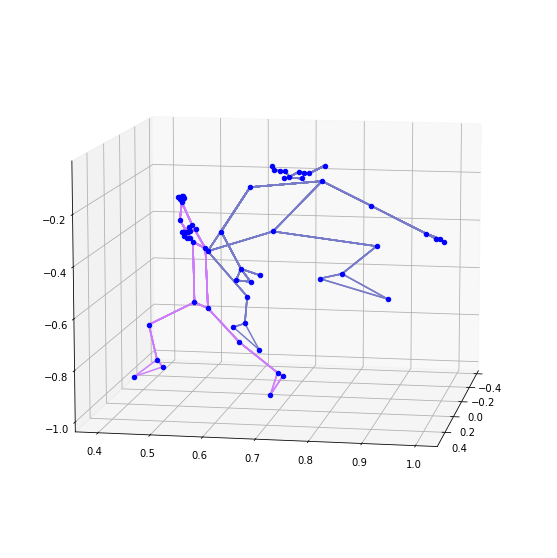

In [40]:
dot_colors=[(0, 0, 255), (0, 0, 255)]
line_colors=[(120, 124, 200), (205, 124, 250)]

plot_multiple_3d_coordinates(results_list, dot_colors, line_colors)

In [41]:
# plotting using procustes

from scipy.spatial import procrustes

In [42]:
r1 = convert_results_to_numpy(inst11_result, _3d=True)
r2 = convert_results_to_numpy(inst_2_result, _3d=True)

In [43]:
r1_dot, r1_dott, loss12 = procrustes(r1, r2) # std version of 2 that best fits 1
r2_dot, r2_dott, loss21 = procrustes(r2, r1)

In [44]:
permutations = [
    [r1, r1_dott], 
    [r1_dott, r2], 
    [r2, r2_dott], 
    [r2_dott, r1], 
    [r1_dott, r2_dott]
]

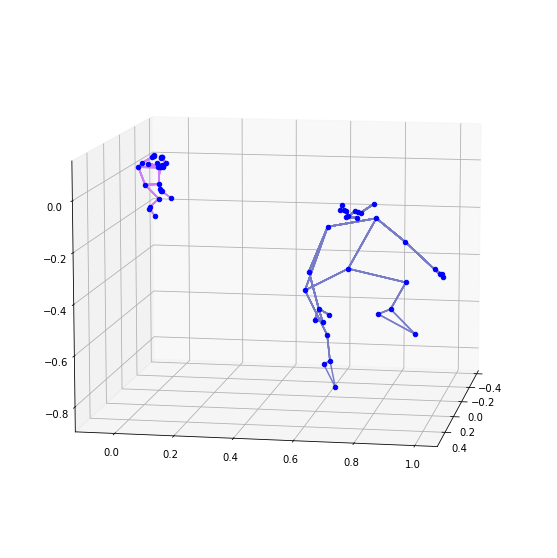

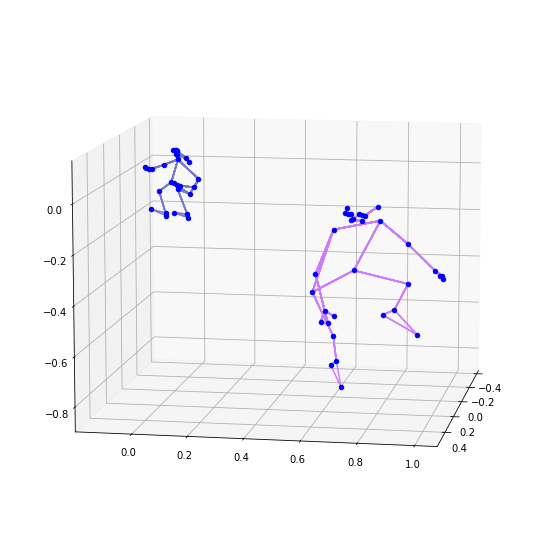

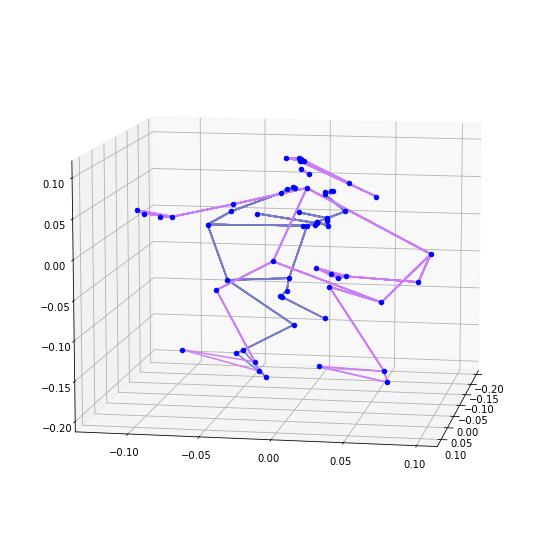

In [45]:
for p in permutations:
    plot_multiple_3d_coordinates(p, dot_colors, line_colors)

In [226]:
path2 = '/home/anindya/Documents/Atelta/AteltaWebStream/RawData/UnderTheInfluenceChoreo.mp4'

In [81]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5


def plot_landmarks(
    landmark_list,
    connections=None,
):
    if not landmark_list:
        return
    plotted_landmarks = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        if (
            landmark.HasField("visibility")
            and landmark.visibility < _VISIBILITY_THRESHOLD
        ) or (
            landmark.HasField("presence") and landmark.presence < _PRESENCE_THRESHOLD
        ):
            continue
        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
    if connections:
        out_cn = []
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    f"Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx],
                    plotted_landmarks[end_idx],
                ]
                out_cn.append(
                    dict(
                        xs=[landmark_pair[0][0], landmark_pair[1][0]],
                        ys=[landmark_pair[0][1], landmark_pair[1][1]],
                        zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    )
                )
        cn2 = {"xs": [], "ys": [], "zs": []}
        for pair in out_cn:
            for k in pair.keys():
                cn2[k].append(pair[k][0])
                cn2[k].append(pair[k][1])
                cn2[k].append(None)

    df = pd.DataFrame(plotted_landmarks).T.rename(columns={0: "z", 1: "x", 2: "y"})
    df["lm"] = df.index.map(lambda s: mp_pose.PoseLandmark(s).name).values
    fig = (
        px.scatter_3d(df, x="z", y="x", z="y", hover_name="lm")
        .update_traces(marker={"color": "red"})
        .update_layout(
            margin={"l": 0, "r": 0, "t": 0, "b": 0},
            scene={"camera": {"eye": {"x": 2.1, "y": 0, "z": 0}}},
        )
    )
    fig.add_traces(
        [
            go.Scatter3d(
                x=cn2["xs"],
                y=cn2["ys"],
                z=cn2["zs"],
                mode="lines",
                line={"color": "black", "width": 5},
                name="connections",
            )
        ]
    )

    return fig

In [82]:
plot_landmarks(inst12_result.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)

In [83]:
plot_landmarks(inst_2_result.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)

  0%|          | 0/200 [00:00<?, ?it/s]

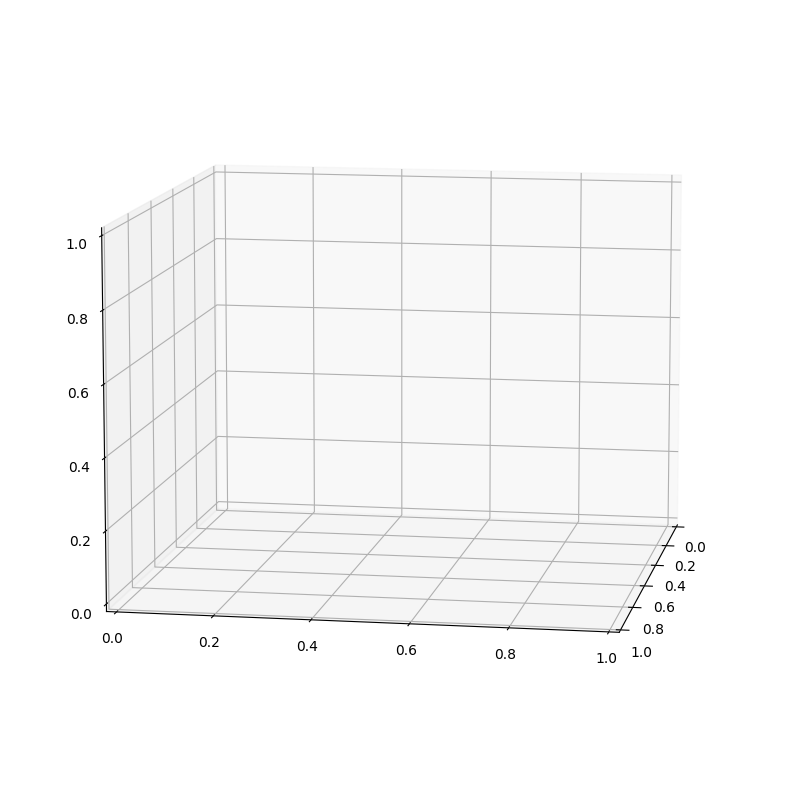

In [244]:
from tqdm.notebook import tqdm

cap = cv2.VideoCapture(path2)

plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.view_init(elev=elevation, azim=azimuth)

images = []


total=200
with tqdm(total=total) as pbar:
    for c in range(total):
        ret, frame = cap.read()
        if ret:
            res = predict_on_image(frame, draw=False)
            if res:
                fig = plot_landmarks(res.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)
                images.append(fig)
                pbar.update(1)

In [237]:
fig = plot_landmarks(inst12_result.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)

In [246]:
for fig in images:
    fig

In [251]:
images[56]

### Using procustes library

In [46]:
r1 = convert_results_to_numpy(inst11_result, _3d=True)
r2 = convert_results_to_numpy(inst_2_result, _3d=True)

In [47]:
def plot_3d(pts, color):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    for pt in pts:
        x, y, z = pt 
        ax.scatter3D(
                xs=[-z], ys=[x], zs=[-y], 
                color=_normalize_color(color)
            )
    plt.show()

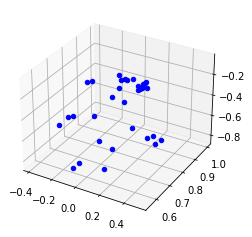

In [48]:
plot_3d(r1, dot_colors[0])

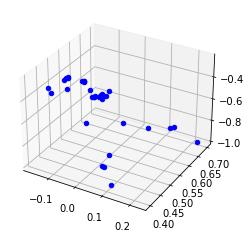

In [49]:
plot_3d(r2, dot_colors[1])

In [50]:
def plot_multiple_3d(pts_list, colors):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    def _plot3D(pts, color):
        for pt in pts:
            x, y, z = pt 
            ax.scatter3D(xs=[-z], ys=[x], zs=[-y], color=_normalize_color(color))
    
    for pts, color in zip(pts_list, colors):
        _plot3D(pts, color)
    plt.show()

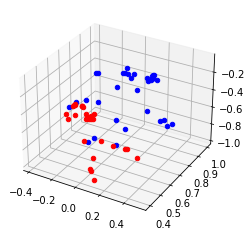

In [51]:
dot_colors = [(0, 0, 255), (255, 0, 0)]
plot_multiple_3d([r1, r2], dot_colors)

In [52]:
def rmse(r1, r2):
    return np.sqrt(np.mean(np.sum((r1 - r2)**2, axis=1)))

In [53]:
rmse(r1, r2)

0.4942954765833744

In [54]:
from procrustes import rotational

In [55]:
result = rotational(r1, r2, translate=True)

In [56]:
r1_at = np.dot(result.new_a, result.t)

In [57]:
rmse(r1_at, result.new_b)

0.27355719023536457

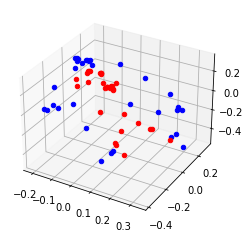

In [58]:
plot_multiple_3d([r1_at, result.new_b], dot_colors)

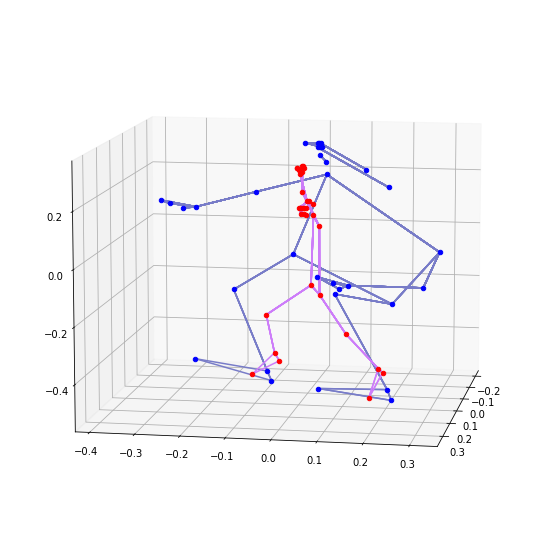

In [59]:
results_list = [r1_at, result.new_b]
plot_multiple_3d_coordinates(results_list, dot_colors, line_colors)

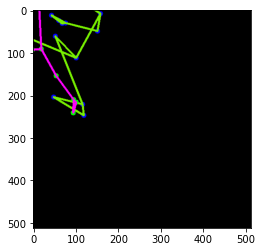

In [75]:
def draw_keypoints(image: np.ndarray, 
                   landmarks: Union[list, np.ndarray], connection: List[Tuple[int, int]], 
                   dot_color: Tuple[int, int, int], line_color: Tuple[int, int,int], 
                   diameter=6,line_width=3) -> None:
    height, width, _ = image.shape
    
    keypoints = []
    for idx, landmark in enumerate(landmarks):
        x, y = landmark

        x_px = int(min(math.floor(x * width), width - 1))
        y_px = int(min(math.floor(y * height), height - 1))
        keypoints.append((x_px, y_px))
        cv2.circle(image, (int(x_px), int(y_px)), diameter, dot_color, -1)
    
    for inx, conn in enumerate(connection):
        from_ = conn[0]
        to_ = conn[1]
    
        if keypoints[from_] and keypoints[to_]:
            cv2.line(image, keypoints[from_], keypoints[to_], line_color, line_width)
        else:
            continue
    return image



draw_landmarks_from_landmark(
    landmarks_list=[r1_at[:, :-1], result.new_b[:, :-1]], 
    dot_colors=[(0, 0, 255), (0, 255, 0)], 
    line_colors=[(120, 240, 0), (314, 0, 400)], 
    canvas_shape=(512, 512, 3)
)

### Bi-partite Graph Matching

In [72]:
latest = [
    convert_results_to_numpy(inst11_result), 
    convert_results_to_numpy(inst_2_result)
]

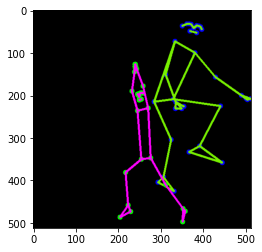

In [76]:



draw_landmarks_from_landmark(
    landmarks_list=latest, 
    dot_colors=[(0, 0, 255), (0, 255, 0)], 
    line_colors=[(120, 240, 0), (314, 0, 400)], 
    canvas_shape=(512, 512, 3)
)

In [99]:
from plot3d import plot_mutiple_plotly_landmarks

In [100]:
latest3d = [
    convert_results_to_numpy(inst11_result, _3d=True), 
    convert_results_to_numpy(inst_2_result, _3d=True)
]

plot_mutiple_plotly_landmarks([latest3d[0]])